In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
import os
import suspect
import multiprocessing as mp
plt.rcParams['figure.figsize'] = [10, 7]

In [2]:
os.getcwd()

'/home/orco/data/MacroMols/MRS/MacroMols_7T/code'

## 1. Preprocess Fullspectra

In [3]:
# Macromolecule files are the TWIX (.dat) files with ad-special

In [4]:
specs = glob.glob('/home/orco/data/MacroMols/MRS/MacroMols_7T/rawdata/sub-*/mrs/*lr-special.dat')
#mm_dats = sorted(mm_dats, key=lambda x: x.split('.')[1].split('_')[-2])
specs

['/home/orco/data/MacroMols/MRS/MacroMols_7T/rawdata/sub-703/mrs/sub-703_nuc-1H_loc-acc_spec-lr-special.dat',
 '/home/orco/data/MacroMols/MRS/MacroMols_7T/rawdata/sub-703/mrs/sub-703_nuc-1H_loc-wm_spec-lr-special.dat',
 '/home/orco/data/MacroMols/MRS/MacroMols_7T/rawdata/sub-703/mrs/sub-703_nuc-1H_loc-pcc_spec-lr-special.dat',
 '/home/orco/data/MacroMols/MRS/MacroMols_7T/rawdata/sub-706/mrs/sub-706_nuc-1H_loc-acc_spec-lr-special.dat',
 '/home/orco/data/MacroMols/MRS/MacroMols_7T/rawdata/sub-706/mrs/sub-706_nuc-1H_loc-pcc_spec-lr-special.dat',
 '/home/orco/data/MacroMols/MRS/MacroMols_7T/rawdata/sub-706/mrs/sub-706_nuc-1H_loc-wm_spec-lr-special.dat',
 '/home/orco/data/MacroMols/MRS/MacroMols_7T/rawdata/sub-702/mrs/sub-702_nuc-1H_loc-acc_spec-lr-special.dat',
 '/home/orco/data/MacroMols/MRS/MacroMols_7T/rawdata/sub-702/mrs/sub-702_nuc-1H_loc-pcc_spec-lr-special.dat',
 '/home/orco/data/MacroMols/MRS/MacroMols_7T/rawdata/sub-702/mrs/sub-702_nuc-1H_loc-wm_spec-lr-special.dat',
 '/home/orco/

In [22]:
#specs = [specs[-4]]
#specs

['/home/orco/data/MacroMols/MRS/MacroMols_7T/rawdata/sub-704/mrs/sub-704_nuc-1H_loc-wm_spec-lr-special.dat']

In [24]:
water = [i.replace('lr-special.dat','lr-special_water_woOVS.dat') for i in specs]

In [25]:
water

['/home/orco/data/MacroMols/MRS/MacroMols_7T/rawdata/sub-704/mrs/sub-704_nuc-1H_loc-wm_spec-lr-special_water_woOVS.dat']

## 1.1 Average every two Averages



    Near, Jamie & Harris, Ashley & Juchem, Christoph & Kreis, Roland & Marjańska, Małgorzata & Öz, Gülin & Slotboom, Johannes & Wilson, Martin & Gasparovic, Charles. (2020). Preprocessing, analysis and quantification in single-voxel magnetic resonance spectroscopy: experts' consensus recommendations. NMR in Biomedicine. e4257. 10.1002/nbm.4257.


In [26]:
%%time
specs_data = [suspect.io.load_twix(i) for i in specs]


CPU times: user 1.31 s, sys: 50.6 ms, total: 1.36 s
Wall time: 1.36 s


In [27]:
waters = [suspect.io.load_twix(i) for i in water]

(5.0, 0.0)

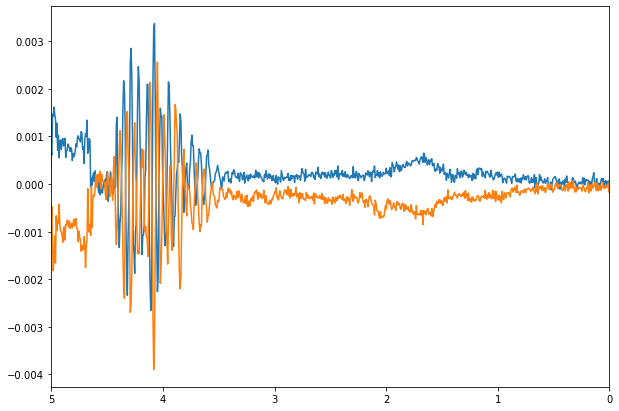

In [28]:
plt.plot(specs_data[0][0,0].frequency_axis_ppm(), specs_data[0][0,0].spectrum().real)
plt.plot(specs_data[0][1,0].frequency_axis_ppm(), specs_data[0][1,0].spectrum().real)
plt.xlim([5,0])

## 2. Average every odd with every even acquisition

In [29]:
def mean_everytwo(mm1):
    mm1_everytwo = []
    for i in range(0,mm1.shape[0]-1,2):
        mm1_everytwo.append((mm1[i]+mm1[i+1])/2)
    return mm1.inherit(np.array(mm1_everytwo))


In [30]:
specs_data[0].shape

(64, 32, 4096)

In [31]:
def _avg_everytwo(arr):
    return 0.5*(arr[0::2,:, :] + arr[1::2,:, :])

In [32]:
%%time
#avg_everytwo_data = [mean_everytwo(i) for i in mms]
#avg_everytwo_water = [mean_everytwo(i) for i in waters]

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.81 µs


In [33]:
%%time
avg_everytwo_data = [_avg_everytwo(i) for i in specs_data]
avg_everytwo_water = [_avg_everytwo(i) for i in waters]

CPU times: user 14 ms, sys: 11.3 ms, total: 25.2 ms
Wall time: 24.6 ms


In [34]:
avg_everytwo_data[0].shape

(32, 32, 4096)

In [35]:
del(specs_data)
del(waters)

In [36]:
#[i.shape for i in avg_everytwo]

## 1.2 Coil combination

In [37]:
def coil_combine(mrs):
    coil_combined = []
    for i in range(mrs.shape[0]):
        weights = suspect.processing.channel_combination.svd_weighting(mrs[i,:,:])
        coil_combined.append(suspect.processing.channel_combination.combine_channels(mrs[i,:,:],weights))
    return mrs.inherit(np.array(coil_combined))

In [38]:
#Rodgers, C. T., & Robson, M. D. (2010). Receive array magnetic resonance spectroscopy: Whitened singular value decomposition (WSVD) gives optimal Bayesian solution. Magnetic Resonance in Medicine, 63(4), 881–891
def coil_combine(data, wref, noise_points=None):
    if not noise_points:
        noise_points = int(data.shape[-1]/8)
    noise = data[:,:,-noise_points:]
    noise = np.moveaxis(noise, -2, 0).reshape((32, -1))
    white_data = suspect.processing.channel_combination.whiten(data, noise)
    white_wref = suspect.processing.channel_combination.whiten(wref, noise)
    noise = white_data[:, :, -noise_points:]
    channel_weights = suspect.processing.channel_combination.svd_weighting(np.mean(white_wref, axis=0))
    cc_data = suspect.processing.channel_combination.combine_channels(white_data, channel_weights)
    cc_wref = suspect.processing.channel_combination.combine_channels(white_wref, channel_weights)
    return cc_data, cc_wref

In [39]:
%%time
cc_data = list()
cc_wref = list()
for n in range(len(avg_everytwo_data)):
    d,w = coil_combine(avg_everytwo_data[n],avg_everytwo_water[n])
    cc_data.append(d)
    cc_wref.append(w)

CPU times: user 1.97 s, sys: 50.3 ms, total: 2.02 s
Wall time: 66 ms


In [40]:
cc_data[0].shape

(32, 4096)

In [41]:
#cc_data = [coil_combine(i) for i in avg_everytwo]

In [42]:
spectra = cc_data[9].spectrum()
frequency_slice = spectra.slice_ppm(4.2, 0)
plt.imshow(spectra[:, frequency_slice].T.real, extent=[0, 32, 0, 4.2], aspect='auto')

IndexError: list index out of range

In [43]:
type(cc_data[0])

suspect.mrsobjects.MRSData

## 1.3 Frequency correction

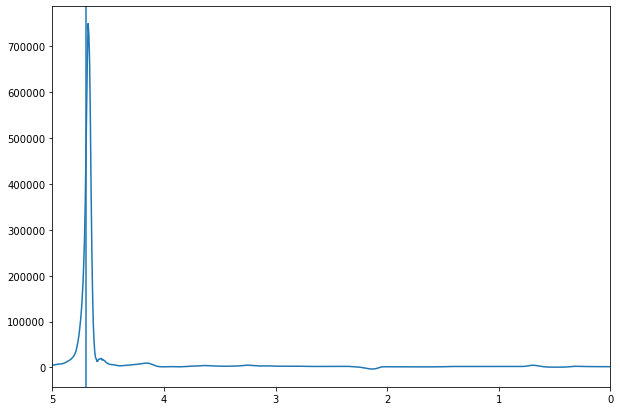

In [44]:
first = cc_wref[0][1]
plt.plot(first.frequency_axis_ppm(), first.spectrum().real)
plt.xlim([5,0])
plt.axvline(4.7)

In [45]:
corr = suspect.processing.frequency_correction.residual_water_alignment(first)
first = first.adjust_frequency(-corr)
corr

5.859375

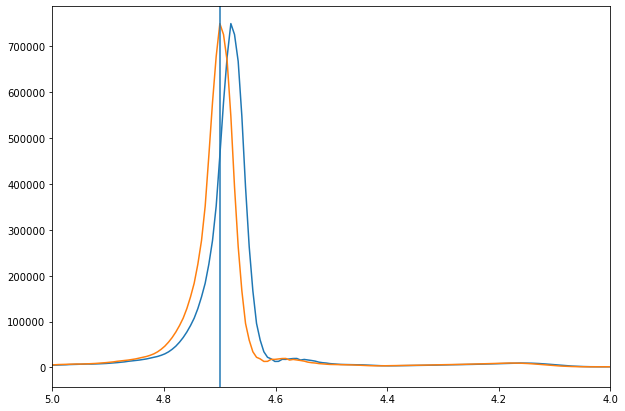

In [46]:
plt.plot(first.frequency_axis_ppm(), first.adjust_frequency(corr).spectrum().real)
plt.plot(first.frequency_axis_ppm(), first.adjust_frequency(0).spectrum().real)
plt.xlim([5,4])
plt.axvline(4.7)

In [47]:
w_freq_corr  = [suspect.processing.frequency_correction.correct_frequency_and_phase(i,first) for i in cc_wref]

In [48]:
first = cc_data[9][7]
plt.plot(first.frequency_axis_ppm(), first.adjust_phase(-0,).adjust_frequency(7).spectrum().real)
plt.xlim([7,0])
plt.axvline(1.99)
plt.axvline(4.7)
plt.axvline(3.027)
plt.axvline(0.94)
plt.axhline(0)

IndexError: list index out of range

In [49]:
#first = first.adjust_phase(-3.5,)

In [50]:
first = first.adjust_frequency(7)

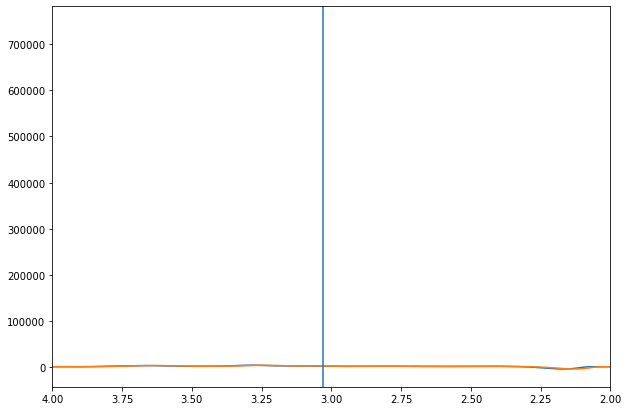

In [51]:
plt.plot(first.frequency_axis_ppm(), first.adjust_frequency(-12).spectrum().real)
plt.plot(first.frequency_axis_ppm(), first.adjust_frequency(0).spectrum().real)
plt.xlim([4,2])
plt.axvline(3.03)

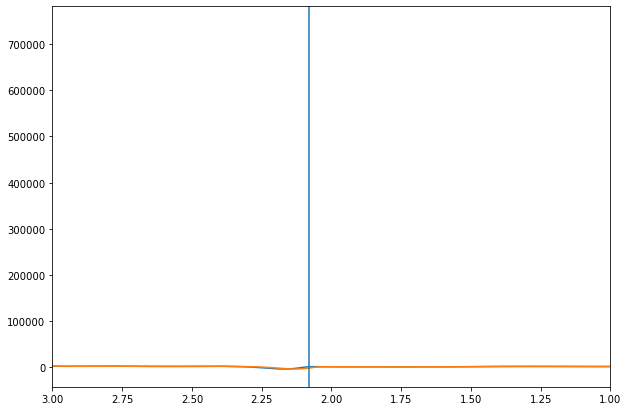

In [52]:
plt.plot(first.frequency_axis_ppm(), first.adjust_frequency(-12).spectrum().real)
plt.plot(first.frequency_axis_ppm(), first.adjust_frequency(0).spectrum().real)
plt.xlim([3,1])
plt.axvline(2.08)

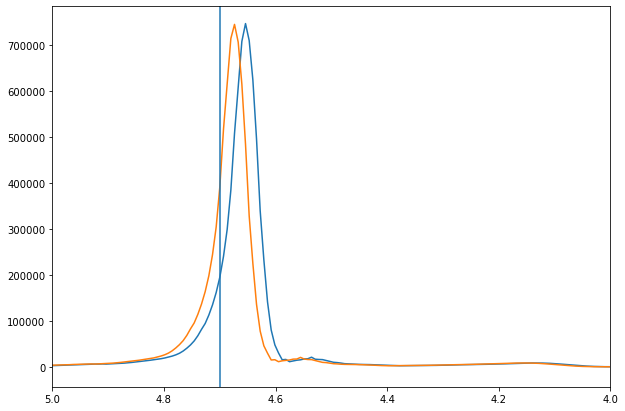

In [53]:
plt.plot(first.frequency_axis_ppm(), first.adjust_frequency(6).spectrum().real)
plt.plot(first.frequency_axis_ppm(), first.adjust_frequency(0).spectrum().real)
plt.xlim([5,4])
plt.axvline(4.7)

## 1.4 Frequency and Phase correction

In [54]:
freq_corr2 = [suspect.processing.frequency_correction.correct_frequency_and_phase(i,i[0]) for i in cc_data]

/home/orco/anaconda3/envs/mrs/lib/python3.9/site-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


In [55]:
sr_spectra = freq_corr2[2].spectrum()
frequency_slice = sr_spectra.slice_ppm(4.2, 0)
plt.imshow(sr_spectra[:, frequency_slice].T.real, extent=[0, 32, 0, 4.2], aspect='auto')

IndexError: list index out of range

In [ ]:
2%4

In [ ]:
figure, axis = plt.subplots(3,5)
for n,i in enumerate(freq_corr2):
    
    spectra = i.spectrum()
    frequency_slice = sr_spectra.slice_ppm(4.2, 0)
    axis[int(n/5),n%5].imshow(spectra[:, frequency_slice].T.real, extent=[0, 32, 0, 4.2], aspect='auto')
    axis[int(n/5),n%5].set_title(specs[n].split('/')[-1][4:22].replace('nuc-1H', ''))
figure.supxlabel('Average')
figure.supylabel('Chemical shift (ppm)')

In [56]:
def freq_corr_all(mrs, ref, method='sr'):
    freq_corr = []
    for i in range(mrs.shape[0]):
        corr = suspect.processing.frequency_correction.spectral_registration(first, mrs[i,:], method=method)
        freq_corr.append(mrs[i,:].adjust_frequency(corr[0]))
    return mrs.inherit(np.array(freq_corr))


# Average Water

In [57]:
w_avg = [np.mean(i,axis=0) for i in w_freq_corr]

In [58]:
water

['/home/orco/data/MacroMols/MRS/MacroMols_7T/rawdata/sub-704/mrs/sub-704_nuc-1H_loc-wm_spec-lr-special_water_woOVS.dat']

In [59]:
der_path = '/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/suspect_preprocessing'
# Save as raw
l = list()
for n, i in enumerate(w_avg):
    l = water[n].split('/')[-1].split('_')
    filename = water[n].split('/')[-1].replace('.dat', 'avg.raw')
    out_path = os.path.join(der_path, l[0], 'mrs')
    os.makedirs(out_path, exist_ok=True)
    out = os.path.join(out_path, filename)
    print(out)
    np.savez(out, mrsdata=i)
    suspect.io.lcmodel.save_raw(out, i)

/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/suspect_preprocessing/sub-704/mrs/sub-704_nuc-1H_loc-wm_spec-lr-special_water_woOVSavg.raw


## 1.5 Average

In [60]:
%%time
averaged = [np.mean(i,axis=0) for i in freq_corr2]

CPU times: user 408 µs, sys: 110 µs, total: 518 µs
Wall time: 309 µs


In [61]:
[i.shape for i in averaged]

[(4096,)]

In [62]:
# ECC

In [63]:
def eddy_correct(spec, water):
    eddy_current = np.unwrap(np.angle(water))
    ec_smooth = suspect.processing.denoising.sliding_gaussian(eddy_current, 32)
    ecc = np.exp(-1j * ec_smooth)
    ecc_data = spec * ecc
    return ecc_data

In [64]:
avg_ecc = list()
for n in range(len(averaged)):
    eddy_current = np.unwrap(np.angle(w_avg[n]))
    ec_smooth = suspect.processing.denoising.sliding_gaussian(eddy_current, 32)
    ecc = np.exp(-1j * ec_smooth)
    ec_data = averaged[n] * ecc
    avg_ecc.append(ec_data)

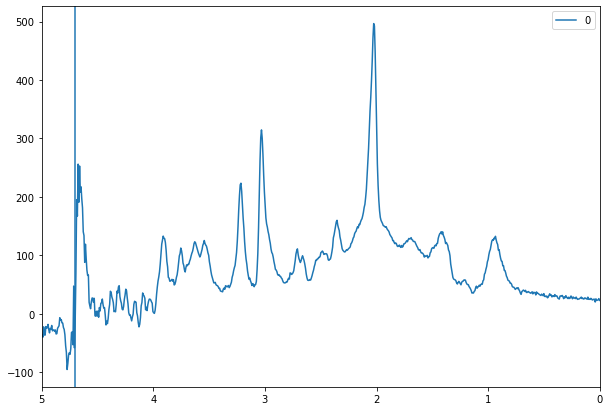

In [65]:
for n,i in enumerate(averaged):
    plt.plot(i.frequency_axis_ppm(), i.spectrum().real, label=n)
plt.xlim([5,0])
#plt.ylim([-2e-4,5e-4])
plt.axvline(4.7)
plt.legend()

In [66]:
avg_ecc = [i.adjust_frequency(17) for i in avg_ecc]

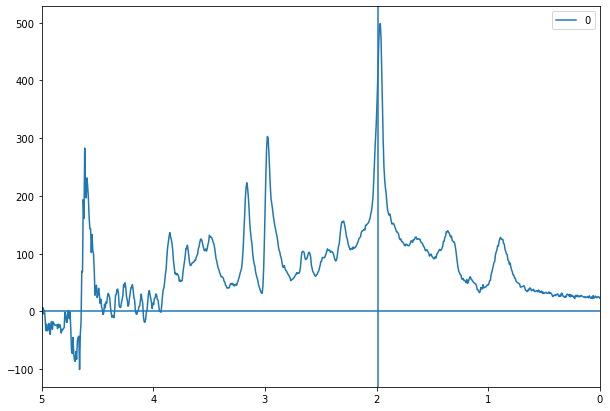

In [67]:
for n,i in enumerate(avg_ecc[:]):
    plt.plot(i.frequency_axis_ppm(), i.spectrum().real, label=n)
plt.xlim([5,0])
#plt.ylim([-2e-4,5e-4])
plt.axvline(1.99)
plt.legend()
plt.axhline(0)

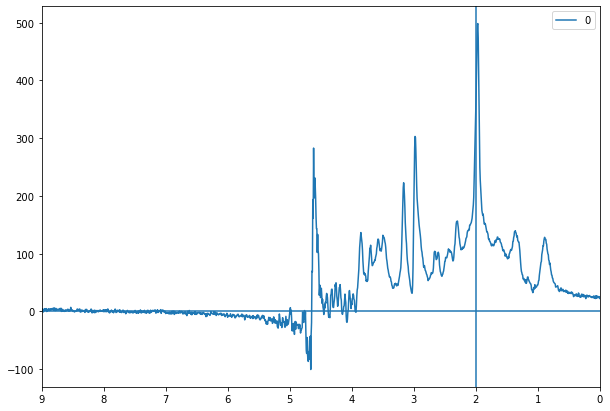

In [68]:
for n,i in enumerate(avg_ecc[:]):
    plt.plot(i.frequency_axis_ppm(), i.spectrum().real, label=n)
plt.xlim([9,0])
#plt.ylim([-2e-4,5e-4])
plt.axvline(1.99)
plt.legend()
plt.axhline(0)

# Frequency adjustment

In [69]:
first = avg_ecc[2]

IndexError: list index out of range

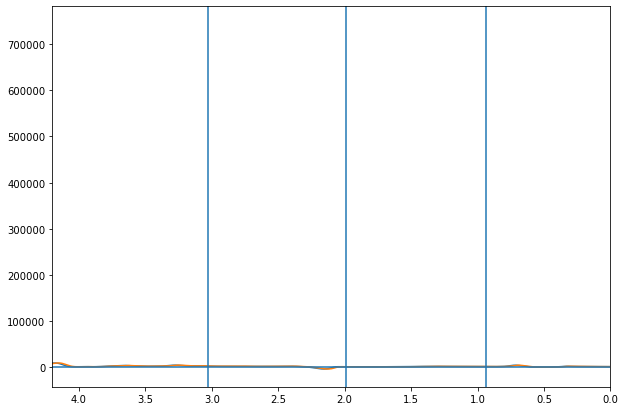

In [70]:
plt.plot(first.frequency_axis_ppm(), first.adjust_phase(0).adjust_frequency(-8).spectrum().real)
plt.plot(first.frequency_axis_ppm(), first.adjust_phase(0).adjust_frequency(0).spectrum().real)
plt.xlim([4.2,0])
#plt.ylim([-100,500])
plt.axvline(1.99)
plt.axvline(4.7)
plt.axvline(3.027)
plt.axvline(0.94)
plt.axhline(0)

In [60]:
first= first.adjust_phase(0).adjust_frequency(-8)

In [61]:
arr_ecc = np.array(avg_ecc)
print(arr_ecc.shape)
arr_ecc = avg_ecc[0].inherit(arr_ecc)

(15, 4096)


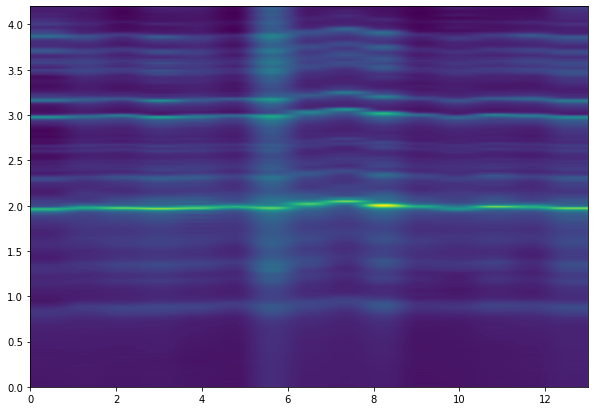

In [62]:
sr_spectra = arr_ecc.spectrum()
frequency_slice = sr_spectra.slice_ppm(4.2, 0)
plt.imshow(sr_spectra[:, frequency_slice].T.real, extent=[0, 13, 0, 4.2], aspect='auto')

In [63]:
def freq_corr_all(mrs, ref, method='sr'):
    freq_corr = []
    for i in range(mrs.shape[0]):
        corr = suspect.processing.frequency_correction.spectral_registration(first, mrs[i,:], method=method)
        freq_corr.append(mrs[i,:].adjust_frequency(corr[0]))
    return mrs.inherit(np.array(freq_corr))

In [74]:
avg_ecc_c = list()
for i in avg_ecc:
    corr = suspect.processing.frequency_correction.spectral_registration(first, i)
    avg_ecc_c.append(i.adjust_frequency(corr[0]))

/home/orco/anaconda3/envs/mrs/lib/python3.9/site-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


(1, 4096)


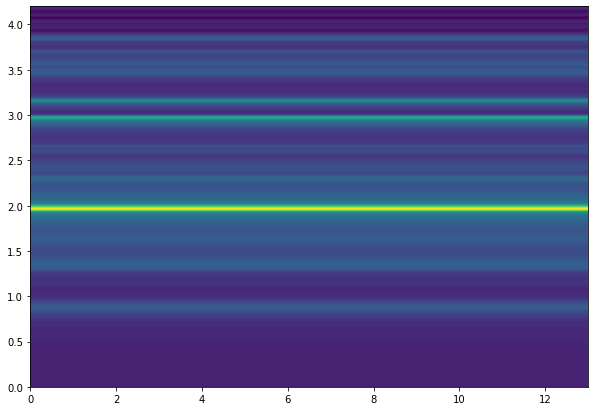

In [75]:
arr_ecc = np.array(avg_ecc_c)
print(arr_ecc.shape)
arr_ecc = avg_ecc_c[0].inherit(arr_ecc)
sr_spectra = arr_ecc.spectrum()
frequency_slice = sr_spectra.slice_ppm(4.2, 0)
plt.imshow(sr_spectra[:, frequency_slice].T.real, extent=[0, 13, 0, 4.2], aspect='auto')

In [71]:
specs

['/home/orco/data/MacroMols/MRS/MacroMols_7T/rawdata/sub-704/mrs/sub-704_nuc-1H_loc-wm_spec-lr-special.dat']

In [72]:
for i in avg_ecc_c[:]:
    plt.plot(i.frequency_axis_ppm(), i.adjust_phase(0).spectrum().real)

plt.xlim([7,0])
#plt.ylim([-100,500])
plt.axvline(4.7)

NameError: name 'avg_ecc_c' is not defined

In [68]:
#mm_dats.pop(0)

In [69]:
der_path = '/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/LC_Model'

In [70]:
i = specs[0].split('/')[-1]

In [71]:
i.split('_')

['sub-703', 'nuc-1H', 'loc-acc', 'spec-lr-special.dat']

In [72]:
os.makedirs

<function os.makedirs(name, mode=511, exist_ok=False)>

In [73]:
suspect.io.lcmodel.save_raw

<function suspect.io.lcmodel.save_raw(filename, data)>

In [74]:
# Save as npz
l = list()
for n, i in enumerate(avg_ecc_c):
    l = specs[n].split('/')[-1].split('_')
    filename = specs[n].split('/')[-1].replace('.dat', 'avg_ecc.raw')
    out_path = os.path.join(der_path, l[0], 'mrs')
    os.makedirs(out_path, exist_ok=True)
    out = os.path.join(out_path, filename)
    print(out)
    np.savez(out, mrsdata=i)
    suspect.io.lcmodel.save_raw(out, i)

/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/LC_Model/sub-703/mrs/sub-703_nuc-1H_loc-acc_spec-lr-specialavg_ecc.raw
/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/LC_Model/sub-703/mrs/sub-703_nuc-1H_loc-wm_spec-lr-specialavg_ecc.raw
/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/LC_Model/sub-703/mrs/sub-703_nuc-1H_loc-pcc_spec-lr-specialavg_ecc.raw
/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/LC_Model/sub-706/mrs/sub-706_nuc-1H_loc-acc_spec-lr-specialavg_ecc.raw
/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/LC_Model/sub-706/mrs/sub-706_nuc-1H_loc-pcc_spec-lr-specialavg_ecc.raw
/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/LC_Model/sub-706/mrs/sub-706_nuc-1H_loc-wm_spec-lr-specialavg_ecc.raw
/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/LC_Model/sub-702/mrs/sub-702_nuc-1H_loc-acc_spec-lr-specialavg_ecc.raw
/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/LC_Model/sub-702/mrs/sub-702_nuc-1H_loc-pcc_spec-lr-specialavg_ec

In [75]:
der_path = '/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/suspect_preprocessing'
# Save as raw
l = list()
for n, i in enumerate(averaged):
    l = specs[n].split('/')[-1].split('_')
    filename = specs[n].split('/')[-1].replace('.dat', 'avg.raw')
    out_path = os.path.join(der_path, l[0], 'mrs')
    os.makedirs(out_path, exist_ok=True)
    out = os.path.join(out_path, filename)
    print(out)
    np.savez(out, mrsdata=i)
    suspect.io.lcmodel.save_raw(out, i)

/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/suspect_preprocessing/sub-703/mrs/sub-703_nuc-1H_loc-acc_spec-lr-specialavg.raw
/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/suspect_preprocessing/sub-703/mrs/sub-703_nuc-1H_loc-wm_spec-lr-specialavg.raw
/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/suspect_preprocessing/sub-703/mrs/sub-703_nuc-1H_loc-pcc_spec-lr-specialavg.raw
/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/suspect_preprocessing/sub-706/mrs/sub-706_nuc-1H_loc-acc_spec-lr-specialavg.raw
/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/suspect_preprocessing/sub-706/mrs/sub-706_nuc-1H_loc-pcc_spec-lr-specialavg.raw
/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/suspect_preprocessing/sub-706/mrs/sub-706_nuc-1H_loc-wm_spec-lr-specialavg.raw
/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/suspect_preprocessing/sub-702/mrs/sub-702_nuc-1H_loc-acc_spec-lr-specialavg.raw
/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/su

In [ ]:
# HLSVD

In [76]:
water_list = list()
dry_list = list()
for spec in avg_ecc_c:
    components = suspect.processing.water_suppression.hsvd(spec, 30)
    water_components = [component for component in components if component["frequency"] < 45]
    water_fid = spec.inherit(suspect.processing.water_suppression.construct_fid(water_components, spec.time_axis()))
    dry_fid = spec - water_fid
    water_list.append(water_fid)
    dry_list.append(dry_fid)

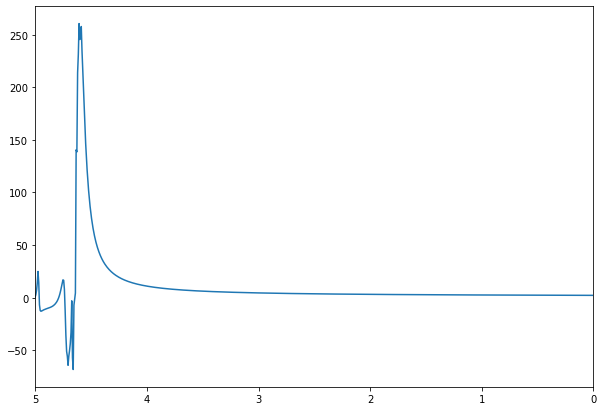

In [77]:
for i in water_list:
    plt.plot(i.frequency_axis_ppm(), 
             i.spectrum().real)
    plt.xlim([5,0])
    #plt.ylim([-2e-4,5e-4])
    #plt.axvline(4.7)

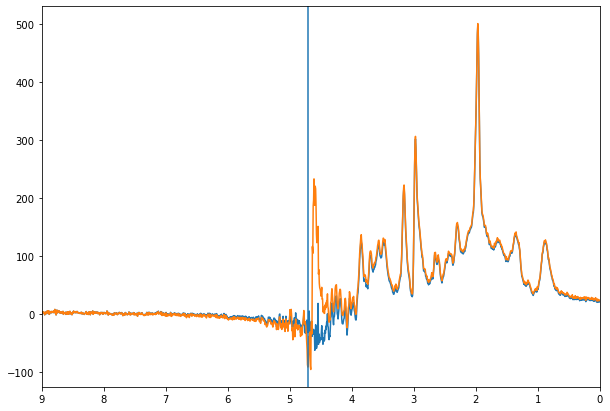

In [79]:
i=0
plt.plot(dry_list[0].frequency_axis_ppm(), dry_list[i].adjust_phase(0,0).spectrum().real)
plt.plot(dry_list[0].frequency_axis_ppm(), avg_ecc_c[i].adjust_phase(0,0).spectrum().real)
plt.xlim([9,0])
#plt.ylim([-2e-4,5e-4])
plt.axvline(4.7)

In [80]:
# Save as npz
l = list()
for n, i in enumerate(dry_list):
    l = specs[n].split('/')[-1].split('_')
    filename = specs[n].split('/')[-1].replace('.dat', 'avg_ecc_hlsvd.raw')
    out_path = os.path.join(der_path, l[0], 'mrs')
    os.makedirs(out_path, exist_ok=True)
    out = os.path.join(out_path, filename)
    print(out)
    np.savez(out, mrsdata=i)
    suspect.io.lcmodel.save_raw(out, i)

/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/suspect_preprocessing/sub-704/mrs/sub-704_nuc-1H_loc-wm_spec-lr-specialavg_ecc_hlsvd.raw


In [ ]:
plt.plot(dry_pcc_avg.frequency_axis_ppm(), dry_pcc_avg.spectrum().real)
plt.xlim([5,0])
#plt.ylim([-2e-4,5e-4])
plt.axvline(4.7)

In [ ]:
dry_pcc_avg = np.array(dry_list).mean(axis=0)
dry_pcc_avg = dry_list[0].inherit(dry_pcc_avg)
out_file = '/home/orco/data/MacroMols/MRS/MacroMols_7T/derivatives/LCModel_averaged/MM_avg_pcc_dry.raw'
suspect.io.lcmodel.save_raw(out_file,dry_pcc_avg)

In [ ]:
plt.plot(averaged[0].frequency_axis_ppm(), averaged[3].adjust_phase(3,1.5e-3).spectrum().real)
plt.xlim([5,0])
plt.ylim([-2e-4,5e-4])
plt.axvline(4.7)